In [22]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [13]:
#path = [r"dataset/train/with_mask",r"dataset/train/without_mask"]

image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3769 files belonging to 2 classes.
Using 3016 files for training.
Found 3769 files belonging to 2 classes.
Using 753 files for validation.


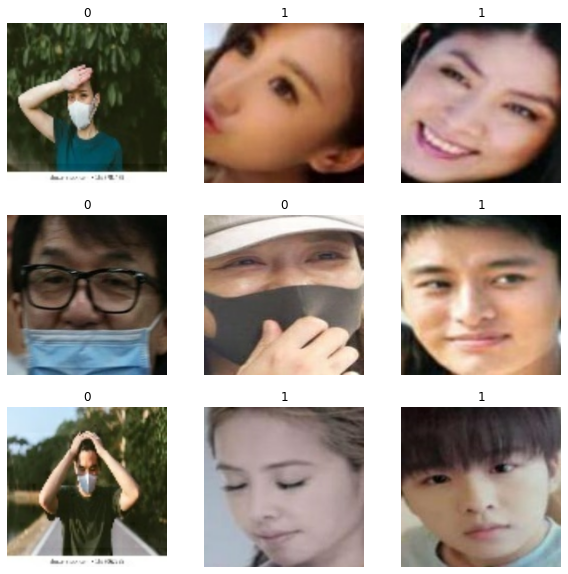

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [18]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

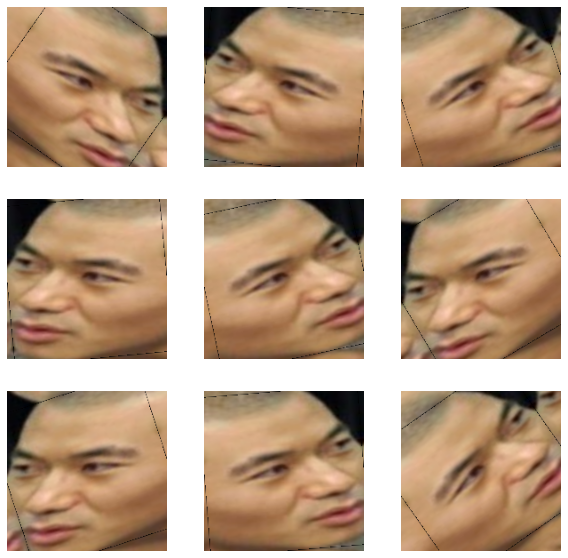

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [21]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [23]:
 def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [24]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
95/95 [==============================] - 650s 7s/step - loss: 0.3353 - accuracy: 0.8700 - val_loss: 0.6997 - val_accuracy: 0.4993
Epoch 2/50
95/95 [==============================] - 627s 7s/step - loss: 0.2278 - accuracy: 0.9128 - val_loss: 0.7093 - val_accuracy: 0.4807
Epoch 3/50
95/95 [==============================] - 610s 6s/step - loss: 0.1737 - accuracy: 0.9344 - val_loss: 0.6597 - val_accuracy: 0.6746
Epoch 4/50
95/95 [==============================] - 687s 7s/step - loss: 0.1545 - accuracy: 0.9400 - val_loss: 0.6071 - val_accuracy: 0.6361
Epoch 5/50
95/95 [==============================] - 692s 7s/step - loss: 0.1380 - accuracy: 0.9526 - val_loss: 0.3866 - val_accuracy: 0.8964
Epoch 6/50
95/95 [==============================] - 679s 7s/step - loss: 0.1305 - accuracy: 0.9479 - val_loss: 0.1068 - val_accuracy: 0.9695
Epoch 7/50
95/95 [==============================] - 666s 7s/step - loss: 0.1268 - accuracy: 0.9536 - val_loss: 0.1606 - val_accuracy: 0.9296
Epoch 8/50
95

In [31]:
model.save('maskDetectorModel')

INFO:tensorflow:Assets written to: maskDetectorModel\assets
